- Title: Lightweight classes for scientific computing using "cached_property"
- Authors: Ashwin Vishnu
- Date: 2018-12-25
- Modified: 2018-12-26
- Tags: fluidfft, fluidsim, optimization
- Category: Tech Talk

In the quest for optimization and fast computation, while using object-oriented programming, it is a typical technique to initialize the linear algebra array operators as class attributes. Especially in ``fluidfft`` we encounter pseudospectral operator classes that look like:

```python
import numpy as np
from fluiddyn.util import mpi

class Operator:
    def __init__(self, *params):
        ...
        [self.KY, self.KX] = np.meshgrid(self.ky_loc, self.kx_loc)
        self.KX2 = self.KX ** 2
        self.KY2 = self.KY ** 2
        self.K2 = self.KX2 + self.KY2
        self.K4 = self.K2 ** 2
        self.K8 = self.K4 ** 2
        self.K = np.sqrt(self.K2)

        self.K_not0 = self.K.copy()
        self.K2_not0 = self.K2.copy()
        self.K4_not0 = self.K4.copy()
        if mpi.rank == 0 or self.is_sequential:
            self.K_not0[0, 0] = 10.0e-10
            self.K2_not0[0, 0] = 10.0e-10
            self.K4_not0[0, 0] = 10.0e-10
        ...
        
```

As you can see, for the purpose of fast computation, we store modified versions of the wavenumber arrays that are used repeatedly later on, during simulation. These arrays may not be required while instantiating the same class for post-processing, and could result in unnecessary delays while loading large simulations.

For demonstrating using a simple example, we can create a class which automatically stores the operator arrays to compute the **derivatives using finite difference schemes**. Specifically we consider a *compact finite difference scheme*, named OUCS3 (Sengupta, T.K., Sircar, S.K. & Dipankar, A., [J Sci Comput (2006) 26: 151](https://doi.org/10.1007/s10915-005-4928-3)).

## Short primer on explicit and compact finite difference schemes

Differentiation using explicit finite difference scheme can be represented as:

$$ \{u'\} = \mathbf{A} \{u\} $$

Where $u$ is a known 1-D vector and $u'$ is the desired first derivative of $u$. For *second-order central difference* ($CD_2$), the "matrix" $\mathbf{A}$ takes the form of a tri-diagonal matrix with repeating elements like:

$$\mathbf{A} = 
 \begin{pmatrix}
  0      &  1/\Delta  & \cdots & 0 \\
  -1/\Delta  & \ddots & \ddots & 0 \\
  \vdots  & \ddots  & \ddots & 1/\Delta  \\
   0 & 0 & -1/\Delta & 0 
 \end{pmatrix}
 $$

Such schemes do not require an array representation and can be substituted with for-loops is compiled languages such as C, Fortran etc. To implement this particular case in Python, they have to be either:

1. represented using sparse matrices to allow for fast dot product, matrix multiplications etc.
2. implemented using compiled functions (Pythran, Cython, Numba etc.) to allow for fast looping over arrays

However irrespective of the programming languages, when we begin to use higher order schemes such as compact finite difference schemes:

\begin{aligned}
\mathbf{B} \{u'\} &= \mathbf{A} \{u\} \\
\{u'\} &= \mathbf{B}^{-1} \mathbf{A} \{u\} \\
\end{aligned}

we end up initializing arrays. Here $\mathbf{A}$ and $\mathbf{B}$ can be sparse matrices, typically pentadiagonal and tridiagonal respectively. The resultant operator, $\mathbf{C} = \mathbf{B}^{-1}\mathbf{A}$ is quite dense, and thus in practice it is easier to compute the derivative in two steps:

1. Matrix multiplication $\mathbf A \{u\} \to \{d\}$
2. Solve $\mathbf B \{u'\} = \{d\}$ iteratively, using TDMA

> **Note**: Boundary conditions (BC) would mean the matrices would be slightly different, but we avoid this consideration in this post, since ``scipy`` does not seem to have special solvers for such matrices. Ideally one would use a Thomas Diagonal Matrix Algorithm / TDMA specially designed for problems with periodic BC.

## Demo

We will be reusing the following `Base` class to store the input parameters for OUCS3

In [1]:
%matplotlib inline
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import inv
import seaborn as sns


class Base:
    def __init__(self, L, N, alpha=0.0):
        """Gather input parameters for OUCS3
        
        Parameters
        ----------
        L: float
            length of the domain
        N: int
            number of points
        alpha: float
            upwind factor, adds numerical dissipation
        
        """
        # Scalar parameters
        self.L = L
        self.N = N

        delta = L / (N - 1)
        
        a0 = -11 * alpha / 150
        a1 = 1.57557379 / 2.0 + alpha / 30.0
        a2 = 0.183205192 / 4.0 + alpha / 300.0
        
        b0 = 1.0
        b1 = 0.3793894912 + alpha / 60.0
        
        # Create pentadiagonal matrix, A
        self.A = diags(
            np.array([-a2, -a1, a0, a1, a2]) / delta,
            [-2, -1, 0, 1, 2,],
            shape=(N, N),
            format="csc"
        )
    
        # Create tridiagonal matrix, B
        self.B = diags(
            [b1, b0, b1],
            [-1, 0, 1],
            shape=(N, N),
            format="csc"
        )

    def diff(self, u):
        Au = self.A @ u
        # inefficient alternative
        return inv(self.B) @ Au
        
    def plot(self, **fields):
        fields.update({"x": np.linspace(0, self.L, self.N)})
        for field in fields:
            if field != "x":
                sns.lineplot("x", field, data=fields, label=field)

Have a look at how the arrays look like

In [2]:
o = Base(4 * np.pi, 6)
print("\nA = \n", o.A.toarray())
print("\nB = \n", o.B.toarray())


A = 
 [[ 0.          0.31345045  0.01822376  0.          0.          0.        ]
 [-0.31345045  0.          0.31345045  0.01822376  0.          0.        ]
 [-0.01822376 -0.31345045  0.          0.31345045  0.01822376  0.        ]
 [ 0.         -0.01822376 -0.31345045  0.          0.31345045  0.01822376]
 [ 0.          0.         -0.01822376 -0.31345045  0.          0.31345045]
 [ 0.          0.          0.         -0.01822376 -0.31345045  0.        ]]

B = 
 [[1.         0.37938949 0.         0.         0.         0.        ]
 [0.37938949 1.         0.37938949 0.         0.         0.        ]
 [0.         0.37938949 1.         0.37938949 0.         0.        ]
 [0.         0.         0.37938949 1.         0.37938949 0.        ]
 [0.         0.         0.         0.37938949 1.         0.37938949]
 [0.         0.         0.         0.         0.37938949 1.        ]]


We can inherit the class to use an efficient algorithm to solve such arrays, such as ``scipy.linalg.solve_toeplitz`` which does not accept sparse arrays as inputs.

In [3]:
from scipy.linalg import solve_toeplitz

class OUCS3(Base):
    """A class to perform OUCS3 compact scheme finite differentiation."""
    def diff(self, u):
        Au = self.A @ u
        B_column = self.B[:,0].toarray()
        B_row = self.B[0,:].toarray()
        return solve_toeplitz((B_column, B_row), Au)

### Test that everything works

Let's compare derivatives of a gaussian pulse computed using OUCS3 and explicit finite difference schemes.

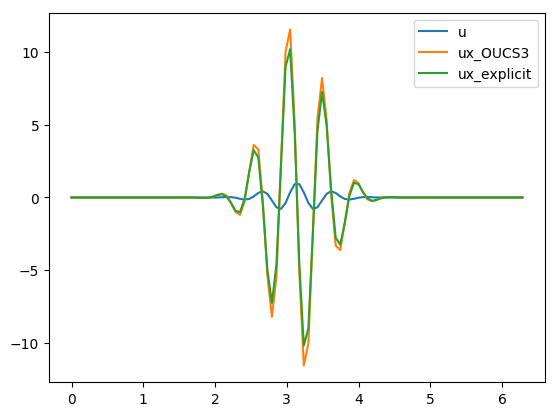

In [4]:
from scipy.signal import gausspulse

def init_params_fields(N):
    """Initialize parameters and generate a gaussian pulse."""
    L = 2 * np.pi
    x = np.linspace(0, L, N)

    u = gausspulse(abs(x - L/2), fc=2)
    return L, N, x, u

L, N, x, u = init_params_fields(100)

oper = OUCS3(L, N)
ux = oper.diff(u)

oper.plot(u=u, ux_OUCS3=ux, ux_explicit=np.gradient(u, x))

#### Cost of instantiation and computing derivatives

Let us have a look at the time consumed in instantiating the class. We will use

* $N=1000$ (typical array size for a well resolved 1D simulation)

We might extend what we observe here to 2D ($N=1000^2$) and 3D simulations ($N=100^3$ to $N=1000^3$). We shall use the package `line_profiler` to time the time elapsed in each line. The system has been tuned using `perf` package to reduce jitter.

In [5]:
%load_ext line_profiler

def profile_OUCS3(N):
    L, N, x, u = init_params_fields(N)
    oper = OUCS3(L, N)  # instantiate
    ux = oper.diff(u)   # compute derivative

%lprun -f profile_OUCS3 -f OUCS3.diff profile_OUCS3(1_000)

Timer unit: 1e-06 s

Total time: 0.01216 s
File: <ipython-input-3-12c24f274ae1>
Function: diff at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                               def diff(self, u):
     6         1         87.0     87.0      0.7          Au = self.A @ u
     7         1       1579.0   1579.0     13.0          B_column = self.B[:,0].toarray()
     8         1       1648.0   1648.0     13.6          B_row = self.B[0,:].toarray()
     9         1       8846.0   8846.0     72.7          return solve_toeplitz((B_column, B_row), Au)

Total time: 0.015373 s
File: <ipython-input-5-3ad1c1c5fdb7>
Function: profile_OUCS3 at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def profile_OUCS3(N):
     4         1        342.0    342.0      2.2      L, N, x, u = init_params_fields(N)
     5         1       2846.0   2846.0     18.5      oper = OUCS3(L, N)  # instantiate
  

The instantiation just takes over a millisecond and secondary arrays `B_column` and `B_row` takes around a millisecond each, taking a combined time of around $20 \%$ of the method `diff`. Even at this scale, we see it can be benificial to store `B_column` and `B_array` as attributes.

## HOWTO: create a lightweight class with cached attributes

Let us begin by inheriting the `Base` class wherein the `diff` method uses stored values for `B_column` and `B_row`.

In [6]:
from scipy.linalg import solve_toeplitz

class BaseCached(Base):
    def diff(self, u):
        Au = self.A @ u
        B_column = self._B_column
        B_row = self._B_row
        return solve_toeplitz((B_column, B_row), Au)

#### First run

If we are not going to rely on a third-party packages, we can do the following now (with Python 3) with `functools.lru_cache` ([docs](https://docs.python.org/3/library/functools.html?highlight=lru_cache#functools.lru_cache)).

In [7]:
from functools import lru_cache
    
class OUCS3Native(BaseCached):
    """A native implementation of a ``cached_property``."""
    @property
    @lru_cache(maxsize=2)
    def _B_column(self):
        return self.B[:,0].toarray()

    @property
    @lru_cache(maxsize=2)
    def _B_row(self):
        return self.B[0,:].toarray()

In [8]:
L, N, x, u = init_params_fields(1_000)
oper_native = OUCS3Native(L, N)

In [9]:
%lprun -f OUCS3Native.diff oper_native.diff(u)

Timer unit: 1e-06 s

Total time: 0.011203 s
File: <ipython-input-6-b2308b39973e>
Function: diff at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                               def diff(self, u):
     5         1        155.0    155.0      1.4          Au = self.A @ u
     6         1       1783.0   1783.0     15.9          B_column = self._B_column
     7         1       1649.0   1649.0     14.7          B_row = self._B_row
     8         1       7616.0   7616.0     68.0          return solve_toeplitz((B_column, B_row), Au)

#### Second run

In [10]:
%lprun -f OUCS3Native.diff oper_native.diff(u)

Timer unit: 1e-06 s

Total time: 0.006538 s
File: <ipython-input-6-b2308b39973e>
Function: diff at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                               def diff(self, u):
     5         1        139.0    139.0      2.1          Au = self.A @ u
     6         1          3.0      3.0      0.0          B_column = self._B_column
     7         1          1.0      1.0      0.0          B_row = self._B_row
     8         1       6395.0   6395.0     97.8          return solve_toeplitz((B_column, B_row), Au)

It is super quick to access ``_B_column`` and ``_B_row`` in the second run and takes simply microseconds!

## How does it work

The least recently used cache (LRU) optimizes the function call, caches the return value, and returns the cache for future calls if the function parameters were "unchanged".

Such an implementation would be protected from simple initialization attempts such as:

In [11]:
oper_native._B_column = 0

AttributeError: can't set attribute

However it is unsafe and can lead to the following unpredictable behaviours:

* Overwriting the original array after first run does not modify the result:

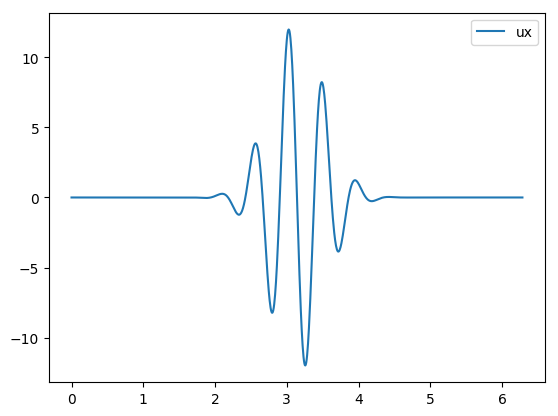

In [12]:
oper_native.B = np.zeros((N,N))

ux = oper_native.diff(u)
oper_native.plot(ux=ux)

* No error is raised when modifying the array in place

In [13]:
oper_native._B_column[:] = 0

* If ``lru_cache(maxsize=None)`` is used it would lead to a potential memory leak.

## Do it better

### Other third-party implementations
1. `werkzeug.utils.cached_property` ([docs](http://werkzeug.pocoo.org/docs/0.14/utils/))
2. `cached_property.cached_property` ([docs](https://github.com/pydanny/cached-property))

These would cache the "property" inside `__dict__` and not in some random location in a memory.

### Werkzeug

In [14]:
from werkzeug.utils import cached_property as wcached_property


class OUCS3Werkzeug(BaseCached):
    """Werkzeug implementation of a ``cached_property``.
    
    """
    @wcached_property
    def _B_column(self):
        return self.B[:,0].toarray()

    @wcached_property
    def _B_row(self):
        return self.B[0,:].toarray()

#### First run

In [15]:
L, N, x, u = init_params_fields(1_000)
oper_wz = OUCS3Werkzeug(L, N)

In [16]:
%lprun -f OUCS3Werkzeug.diff oper_wz.diff(u)

Timer unit: 1e-06 s

Total time: 0.009176 s
File: <ipython-input-6-b2308b39973e>
Function: diff at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                               def diff(self, u):
     5         1        124.0    124.0      1.4          Au = self.A @ u
     6         1        914.0    914.0     10.0          B_column = self._B_column
     7         1        887.0    887.0      9.7          B_row = self._B_row
     8         1       7251.0   7251.0     79.0          return solve_toeplitz((B_column, B_row), Au)

#### Second run

In [17]:
%lprun -f OUCS3Werkzeug.diff oper_wz.diff(u)

Timer unit: 1e-06 s

Total time: 0.010082 s
File: <ipython-input-6-b2308b39973e>
Function: diff at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                               def diff(self, u):
     5         1        508.0    508.0      5.0          Au = self.A @ u
     6         1         11.0     11.0      0.1          B_column = self._B_column
     7         1          4.0      4.0      0.0          B_row = self._B_row
     8         1       9559.0   9559.0     94.8          return solve_toeplitz((B_column, B_row), Au)

### cached_property

In [18]:
from cached_property import cached_property as ccached_property


class OUCS3CachedProperty(BaseCached):
    """Werkzeug implementation of a ``cached_property``.
    
    """
    @ccached_property
    def _B_column(self):
        return self.B[:,0].toarray()

    @ccached_property
    def _B_row(self):
        return self.B[0,:].toarray()

#### First run

In [19]:
L, N, x, u = init_params_fields(1_000)
oper_cp = OUCS3CachedProperty(L, N)

In [20]:
%lprun -f OUCS3CachedProperty.diff oper_cp.diff(u)

Timer unit: 1e-06 s

Total time: 0.010591 s
File: <ipython-input-6-b2308b39973e>
Function: diff at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                               def diff(self, u):
     5         1        149.0    149.0      1.4          Au = self.A @ u
     6         1       1105.0   1105.0     10.4          B_column = self._B_column
     7         1       1935.0   1935.0     18.3          B_row = self._B_row
     8         1       7402.0   7402.0     69.9          return solve_toeplitz((B_column, B_row), Au)

#### Second run

In [21]:
%lprun -f OUCS3CachedProperty.diff oper_cp.diff(u)

Timer unit: 1e-06 s

Total time: 0.006916 s
File: <ipython-input-6-b2308b39973e>
Function: diff at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                               def diff(self, u):
     5         1        141.0    141.0      2.0          Au = self.A @ u
     6         1          3.0      3.0      0.0          B_column = self._B_column
     7         1          1.0      1.0      0.0          B_row = self._B_row
     8         1       6771.0   6771.0     97.9          return solve_toeplitz((B_column, B_row), Au)

### Differences from the native implementation

Overwriting cached property is OK as follows

In [22]:
oper_wz._B_column = 0

In [23]:
oper_cp._B_column = 0

An advantage of such implementation is there is no need to add a ``maxsize`` parameter, and thus no risk of having a memory leak.

The rest of the "caveats" mentioned before still persist in the third-party implementation. I am not sure if it would be possible to raise an `AttributeError` when attempts are made to alter cached property. But this depends on the application, so the caveat can be a feature.

When Python 3.8 becomes available we would have access to a [native implementation](https://docs.python.org/3.8/library/functools.html?highlight=cached_property#functools.cached_property) and we would be able to do:

```python
from functools import cached_property

class OUCS3(BaseCached):
    """A class to perform OUCS3 compact scheme finite differentiation.
    A Python 3.8 implementation of a ``cached_property``.
    
    """
    @cached_property
    def _B_column(self):
        return self.B[:,0].toarray()

    @cached_property
    def _B_row(self):
        return self.B[0,:].toarray()
```

Exciting times ahead.

This post was written entirely in the Jupyter notebook. You can [download](https://fluiddyn.bitbucket.io/src/content/2018/lightweight_classes.ipynb) this notebook, or see a static view [on nbviewer](http://nbviewer.jupyter.org/url/fluiddyn.bitbucket.io/src/content/2018/lightweight_classes.ipynb).